In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp, solve_ivp, odeint, complex_ode
%matplotlib inline

### $\frac{dW}{dx} = \frac{V}{1-x}$
### $\frac{dV}{dx} = \frac{C_1V}{1-x} + C_2 x^{3/2}W$
### $x$ is defined from $1$ to some large value
### BC: 
### $W_{\rm out} = 1$
### $V_{\rm out} = 0$
### Constants:
### $C_1 = 6\alpha/f^\star(\alpha)$
### $C_2 = -8i\sigma_0/f^\star(\alpha)$
### $f(\alpha) = (6i\alpha + 2 + i/\alpha)/(\alpha + 2i)$

In [5]:
def f_alpha(alpha):
    '''
    "Correct" viscosity prescription in Kumar+Pringle 1985
    '''
    return (6j*alpha + 2. + 1j/alpha)/(alpha + 2j)

def calc_C1(alpha):
    '''
    C1 constant in KP85 Eq2.13
    '''
    fa = np.conj(f_alpha(alpha))
    return 6.*alpha/fa

def calc_C2(alpha,sigma):
    '''
    C2 constant in KP85 Eq2.13
    '''
    fa = np.conj(f_alpha(alpha))
    return -8j*sigma/fa

def Q_10(alpha):
    return -3.*alpha/2.
def Q_40(alpha):
    fa = 1. + 2j*alpha + 6.*alpha**2
    fb = 2.*alpha*(2.+1j*alpha)
    return fa/fb
def g_1(alpha):
    return 3.*alpha/Q_40(alpha)
print(g_1(0.01))
def g_2(alpha):
    return (2.*Q_10(alpha))/Q_40(alpha)
print(g_2(0.01))
def g_3(alpha):
    return -1j*150/Q_40(alpha)
def y_approx(x):
    '''
    Approximate solutions for "W" and "V" in 2.16-2.19 of KP85
    '''
    eps = 1. - x
    Win = 1.
    V1  = 150j/(1. +g_1(alpha)) * Win
    W1  = -1.*V1
    V2  = (1./(2. + g_1(alpha)))*((-150j)*Win*3./2. + (g_1(alpha) + g_2(alpha) + 150j)*W1)
    W2  = V2/-2.
    W_approx = Win + eps*W1 + eps*eps*W2
    V_approx = eps*V1 + eps*eps*V2
    return np.array([W_approx,V_approx])
def fun1(x, y):
    return np.vstack([y[1]/(1. - x + 1e-10), C1*y[1]/(1. - x + 1e-10) + C2*x**(3./2.)*y[0]])
def fun(x, y):
    '''    
    Expressions for "W" and "V" in Eq 2.14, 2.15 of KP85
    W ~ y[0]
    V ~ y[1]
    W' = y[1]/(1. - x)
    V' = C1*y[1]/(1. - x) + C2*x**1.5
    '''    
    return np.vstack([y[1]/(1. - x + 1e-10), g_1(alpha)*y[1]/x*(1. - x + 1e-10) + g_2(alpha)*y[1]/x + g_3(alpha)*x**(3./2.)*y[0]])

(0.0011989212943174263-1.7967645299169025e-05j)
(-0.0011989212943174263+1.7967645299169025e-05j)


xout =  0.001
C1 =  (0.0011989212943174258-1.796764529916902e-05j) 
C2 =  (-0.1796764529916902-11.989212943174259j)
(0.9999999999999999+0j) (-0.00017843634251740425+2.984756193662553e-06j)
bc eval =  [0j, 0j]
   Iteration    Max residual    Total nodes    Nodes added  
       1          3.09e-04          100             0       
Solved in 1 iterations, number of nodes 100, maximum relative residual 3.09e-04.
   Iteration    Max residual    Total nodes    Nodes added  
       1          6.16e-04          100             0       
Solved in 1 iterations, number of nodes 100, maximum relative residual 6.16e-04.
   Iteration    Max residual    Total nodes    Nodes added  
       1          2.84e-03          100             1       
       2          2.84e-03          101             1       
       3          2.84e-03          102             1       
       4          2.84e-03          103             1       
       5          2.84e-03          104             1       
       6          2

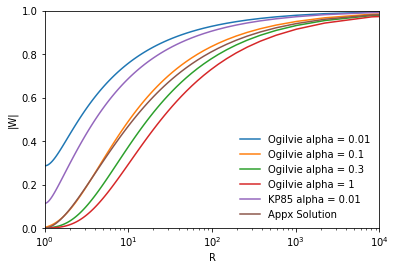

0.7574249508686409


In [7]:
'''
Declare parameters here, which are all from KP85
'''
alpha = 0.01 # alpha viscosity
sigma = 75. # from Kumar+Pringle 1985, corresponds roughly to a = 1 (maximal spin) and H/R ~ 0.1
Rout  = 1e6 # in units of R*
xout  = Rout**(-0.5) # x = (Rout/R*)**(-1/2)
print("xout = ", xout)
C1 = calc_C1(alpha)
C2 = calc_C2(alpha,sigma)
print("C1 = ", C1, "\nC2 = ", C2)


'''
Body of code
'''

#print W_out
# make position array
# x = (R/R*)**(-0.5), so Rout corresponds to the smallest x value
x = np.linspace(xout,1,100)

# Initial guess of solution comes from the Taylor expand "y_approx"
# y[0] is W, y[1] is V
# the first index y[0][0] corresponds to xout (Rout)
# this is a complex quantity
y = np.array(y_approx(x),dtype=np.complex128)
# Renormalize such that the outer tilt value is real-valued and set to 1.0
y[0] *= 1.0/y[0][0]
print(y[0][0], y[0][-1])

## bc should evaluate to zero, where both ya and yb are shape of ( number variables = 2 ), given a correct solution
## ya is the solution to y at point a (which should be x = 1 for us) and yb is the solution for y at point b (which is x = large number for us)
## so, ya[0] and ya[1] are the inner BCs for W, V respectively
## and yb[0], yb[1] are the outer BCs for W, V respectively
def bc(ya, yb):
    '''
    Set outer boundaries (At point b)
    such that:
    W(b) - W_inne
    
    where:
    yb[0] = W(b)
    yb[1] = V(b)
    '''
    ## Check that the inner radius (x=1, corresponding to point "b" in the solve_bvp problem)
    ## has a fixed value, which is determined from our initial conditions which are taylor
    ## expanded near x = 1
    return [yb[0] - y[0][-1], yb[1] - y[1][-1]]

# Should be zero : bc eval minimizes our function
print("bc eval = ", bc(y[:,0],y[:,-1]))




# solve BVP with scipy
# verbose=2 means there is a lot of output
# solve_bvp increases nodes until it finds a solution
result = solve_bvp(fun, bc, x, y,verbose=2,max_nodes=100000)
result1 = solve_bvp(fun1, bc, x, y, verbose=2, max_nodes=100000)
alpha = 0.1
result2 = solve_bvp(fun, bc, x, y,verbose=2,max_nodes=100000)
print(alpha)
alpha = 0.3
result3 = solve_bvp(fun, bc, x, y,verbose=2,max_nodes=100000)
alpha = 1.
print(Q_40(alpha))
print(Q_10(alpha))
print(g_1(alpha))
print(g_2(alpha))
print(g_3(alpha))
result4 = solve_bvp(fun, bc, x, y,verbose=2,max_nodes=100000)
# check if solution worked
# sometimes even if result.success is false, thats just because it doesnt meach
# the tolerance in solve_bvp for being "right", but the solution is still within 1% of the correct solution
print("Status = ", result.status)
print(result1.status)
print("Success = ", result.success)

# result.sol is an output function from solve_bvp for our solution, which we evaluated over x
# 0-th index is "W" solution, 1-th index is "V" solution, which we aren't worrying about here
y_plot = result.sol(x)[0]
y_plot1 = result1.sol(x)[0]
y_plot2 = result2.sol(x)[0]
y_plot3 = result3.sol(x)[0]
y_plot4 = result4.sol(x)[0]
# Convert back to radial units, reversing direction of array
plot_R = np.flip(x**(-2.))
# Tilt comes from the absolute value of the complex quantity y_plot, which we reverse as well
plot_W = np.flip(np.abs(y_plot))
plot_W1= np.flip(np.abs(y_plot1))
plot_W2= np.flip(np.abs(y_plot2))
plot_W3= np.flip(np.abs(y_plot3))
plot_W4= np.flip(np.abs(y_plot4))
# norm is just a check to fix the normalization of solve_bvp so our max tilt is equal to 1.
norm = 1.0/plot_W[-1]
norm1 = 1.0/plot_W1[-1]
norm2 = 1.0/plot_W2[-1]
norm3 = 1.0/plot_W3[-1]
norm4 = 1.0/plot_W4[-1]
plot_W *= norm
plot_W1 *= norm1
plot_W2 *= norm2
plot_W3 *= norm3
plot_W4 *= norm4
print(plot_W4[98])
print(norm)
plt.plot(plot_R,plot_W, label='Ogilvie alpha = 0.01')
plt.plot(plot_R,plot_W2, label='Ogilvie alpha = 0.1')
plt.plot(plot_R,plot_W3, label='Ogilvie alpha = 0.3')
plt.plot(plot_R,plot_W4, label='Ogilvie alpha = 1')
plt.plot(plot_R,plot_W1, label='KP85 alpha = 0.01')
plt.plot(plot_R,np.flip(np.abs(y[0])), label='Appx Solution')
plt.ylim(0,1)
plt.xlim(1.,1e4)
plt.xscale('log')
plt.xlabel("R")
plt.ylabel("|W|")
plt.legend(frameon=False)
plt.show()

### r_try is just some radius we are checking our solution at,to compare with profiles in Kumar+Pringle
r_try = 1e1
print(np.abs(result.sol((r_try)**(-1./2.))[0])*norm)